<a href="https://colab.research.google.com/github/MQasim-Zafar/Business-Data-Analyst-Portfolio/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Project
## Objective
Segment customers based on their purchasing behavior to help with targeted marketing/loyalty campaigns to boost revenue.
## Dataset
Using a sample customer transactions dataset from https://www.kaggle.com/datasets/carrie1/ecommerce-data


## Environment Setup/Requirements


In [24]:
import pandas as pd
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pathlib import Path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🧹 Data Preprocessing

In [7]:
#importing dataset
path = "/content/drive/MyDrive/Colab Notebooks/Customer_Segmentation/data.csv"
df = pd.read_csv(path, encoding='ISO-8859-1', parse_dates=['InvoiceDate'])
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
# Save location for cleaned dataset
PROCESSED = Path('/content/drive/MyDrive/Colab Notebooks/Customer_Segmentation/processed_data.parquet')
PROCESSED.parent.mkdir(parents=True, exist_ok=True)

# 1) Keep only necessary columns
usecols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
df = df[usecols].copy()

# 2) Basic cleaning
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]           # Remove cancellations
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]               # Keep valid values
df = df.dropna(subset=['CustomerID']).copy()                        # Drop missing customers
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)         # Convert to string
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']                 # Add TotalPrice

# 3) Optional outlier clipping
q_low, q_hi = df['TotalPrice'].quantile([0.01, 0.99])
df['TotalPrice'] = df['TotalPrice'].clip(lower=q_low, upper=q_hi)

# Save processed data
df.to_parquet(PROCESSED, index=False)
print(df.shape, 'rows saved to', PROCESSED)

(397884, 9) rows saved to /content/drive/MyDrive/Colab Notebooks/Customer_Segmentation/processed_data.parquet


## 📈 Exploratory Data Analysis

Unique customers: 4338
Unique invoices: 18532
Time range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


/tmp/ipython-input-1237854267.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('InvoiceDate').groupby(pd.Grouper(freq='M'))['TotalPrice'].sum()


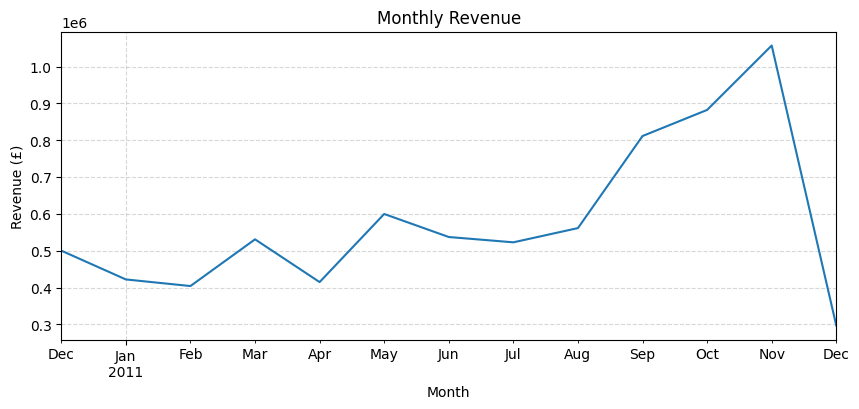

/tmp/ipython-input-1237854267.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


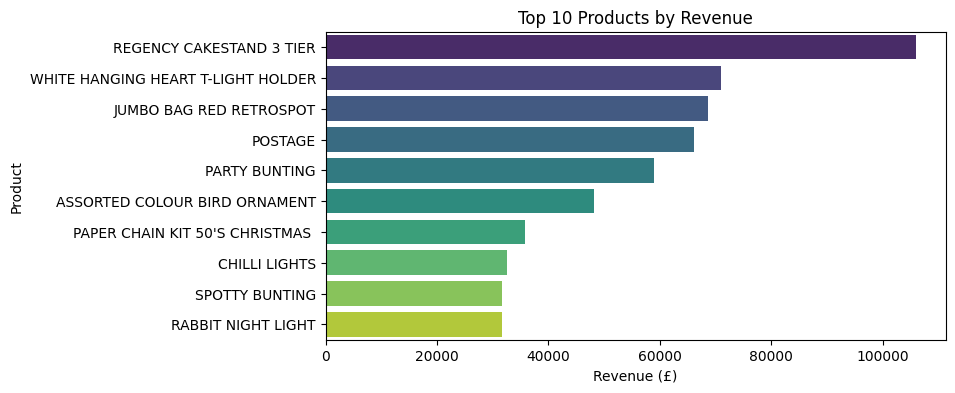

/tmp/ipython-input-1237854267.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue[1:11].values, y=country_revenue[1:11].index, palette="magma")


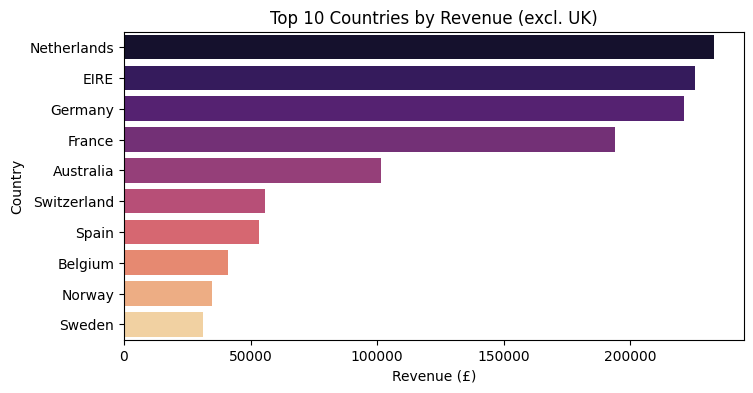

In [18]:
# Load processed data
df = pd.read_parquet(PROCESSED)

print("Unique customers:", df['CustomerID'].nunique())
print("Unique invoices:", df['InvoiceNo'].nunique())
print("Time range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())

# Revenue over time (monthly)
monthly = df.set_index('InvoiceDate').groupby(pd.Grouper(freq='M'))['TotalPrice'].sum()

plt.figure(figsize=(10,4))
monthly.plot()
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue (£)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Top 10 products by revenue
top_products = (df.groupby('Description')['TotalPrice']
                  .sum().sort_values(ascending=False).head(10))

plt.figure(figsize=(8,4))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue (£)")
plt.ylabel("Product")
plt.show()

# Revenue by country (excluding UK)
country_revenue = (df.groupby('Country')['TotalPrice']
                     .sum().sort_values(ascending=False))

plt.figure(figsize=(8,4))
sns.barplot(x=country_revenue[1:11].values, y=country_revenue[1:11].index, palette="magma")
plt.title("Top 10 Countries by Revenue (excl. UK)")
plt.xlabel("Revenue (£)")
plt.ylabel("Country")
plt.show()

## Clustering (K-Means)

In [22]:
#Feature Engineering (RFM + Behavioural)

df = pd.read_parquet(PROCESSED)

# Reference date = 1 day after the latest invoice
ref_date = df['InvoiceDate'].max() + timedelta(days=1)

# Aggregate customer-level features
features = df.groupby('CustomerID').agg(
    last_purchase=('InvoiceDate', 'max'),
    frequency=('InvoiceNo', 'nunique'),
    monetary=('TotalPrice', 'sum'),
    units=('Quantity', 'sum'),
    unique_products=('StockCode', 'nunique'),
    avg_order_value=('TotalPrice', lambda x: x.sum()/x.count())
)

# Recency in days
features['recency'] = (ref_date - features['last_purchase']).dt.days
features = features.drop(columns=['last_purchase'])

# Log-transform skewed variables
for col in ['monetary', 'frequency', 'units', 'unique_products', 'avg_order_value']:
    features[f'log_{col}'] = np.log1p(features[col])

# Final feature set for clustering
X = features[['recency', 'log_monetary', 'log_frequency', 'log_units', 'log_unique_products', 'log_avg_order_value']].copy()
X.columns = ['recency','monetary','frequency','units','variety','aov']

# Save to Drive
FEATURES = Path('/content/drive/MyDrive/Colab Notebooks/Customer_Segmentation/customer_features.parquet')
X.to_parquet(FEATURES, index=True)

print(" Features ready for clustering:", X.shape)
X.head()

✅ Features ready for clustering: (4338, 6)


,recency,monetary,frequency,units,variety,aov
CustomerID,,,,,,
12346,326,5.315666,0.693147,11.214735,0.693147,5.315666
12347,2,8.357940,2.079442,7.807510,4.644391,3.195506
12348,75,7.473489,1.609438,7.758761,3.135494,4.056397
12349,19,7.415205,0.693147,6.448889,4.304065,3.167179
12350,310,5.815324,0.693147,5.288267,2.890372,3.028712


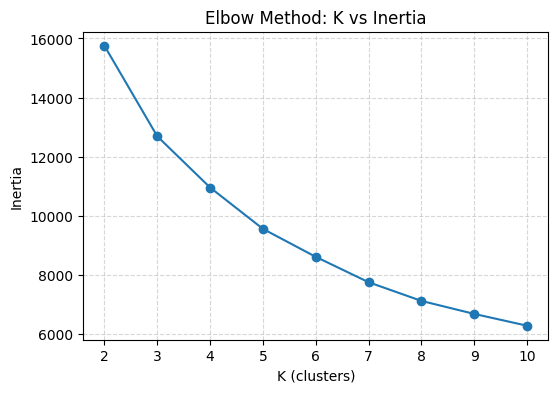

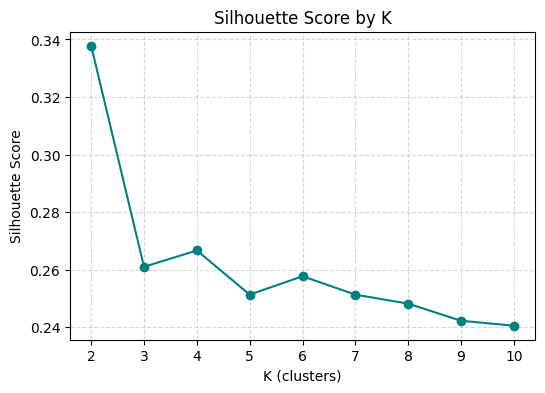

✅ Using K = 3
Cluster distribution:
cluster
0    1267
1    1216
2    1855
Name: count, dtype: int64


In [34]:
# Load features
X = pd.read_parquet(FEATURES)

# Standardize features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Exploring K=2–10 (Elbow & Silhouette)
Ks = range(2, 11)
inertias, sils = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xs, labels))

# Elbow plot
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Method: K vs Inertia")
plt.xlabel("K (clusters)")
plt.ylabel("Inertia")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Silhouette plot
plt.figure(figsize=(6,4))
plt.plot(Ks, sils, marker='o', color='teal')
plt.title("Silhouette Score by K")
plt.xlabel("K (clusters)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Fit final KMeans with 3 clusters for general customers. loyalists and at-risk
best_k = 3
print("✅ Using K =", best_k)

km = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels = km.fit_predict(Xs)

# Attach clusters
clusters = X.copy()
clusters['cluster'] = labels

# Save clustered dataset
CLUSTERS = Path('/content/drive/MyDrive/Colab Notebooks/Customer_Segmentation/customer_clusters.parquet')
clusters.to_parquet(CLUSTERS, index=True)

print("Cluster distribution:")
print(clusters['cluster'].value_counts().sort_index())


The clusters are relatively balanced.

None of the clusters is extremely small or extremely large, which is good for stability. Large imbalances could indicate K is too high or some outliers dominate.

## 📉 Visualizing Clusters

Cluster profiles:
            recency  monetary  frequency     units   variety       aov
cluster                                                               
0        197.324388  5.421868   0.814108  4.709155  2.352040  3.217776
1         30.421875  8.049497   2.185737  7.543536  4.613727  3.074744
2         61.681941  6.365601   1.157847  5.837618  3.674587  2.687567


<Figure size 1000x500 with 0 Axes>

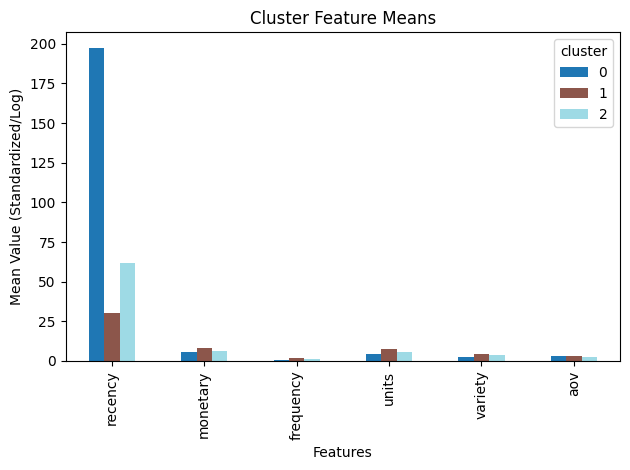

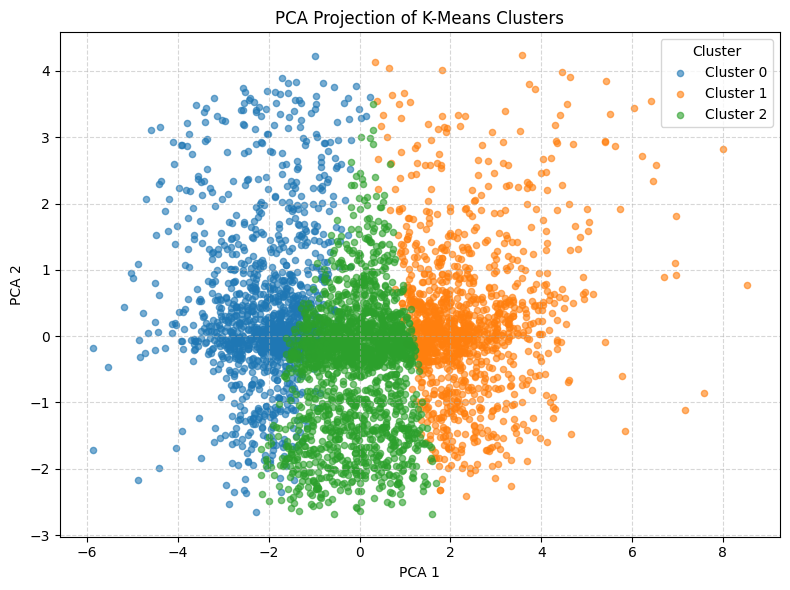

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Load clustered dataset
clusters = pd.read_parquet(CLUSTERS)

# 1️⃣ Cluster profiles (mean of features per cluster)
profile = clusters.groupby('cluster').mean(numeric_only=True)
print("Cluster profiles:")
print(profile)

# Bar chart of cluster feature means
plt.figure(figsize=(10,5))
profile.T.plot(kind='bar', colormap='tab20')
plt.title("Cluster Feature Means")
plt.ylabel("Mean Value (Standardized/Log)")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# 2️⃣ PCA 2D projection
X = clusters[['recency','monetary','frequency','units','variety','aov']]
Xs = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(Xs)

plt.figure(figsize=(8,6))
for c in sorted(clusters['cluster'].unique()):
    idx = clusters['cluster'] == c
    plt.scatter(proj[idx,0], proj[idx,1], s=20, alpha=0.6, label=f'Cluster {c}')
plt.title("PCA Projection of K-Means Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


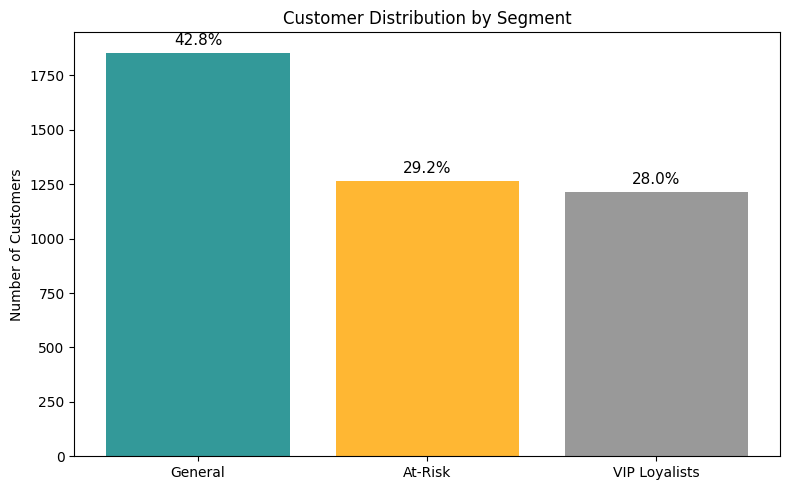

✅ Segment distribution:
segment
General          1855
At-Risk          1267
VIP Loyalists    1216
Name: count, dtype: int64


In [37]:
import matplotlib.pyplot as plt
from pathlib import Path

# Load clustered dataset
clusters = pd.read_parquet(CLUSTERS)

# Map clusters to segments based on feature profiles
profile = clusters.groupby('cluster').mean(numeric_only=True)

segment_name = {}
for cid, row in profile.iterrows():
    if (row['recency'] < profile['recency'].quantile(0.4) and
        row['monetary'] > profile['monetary'].quantile(0.6) and
        row['frequency'] > profile['frequency'].quantile(0.6)):
        segment_name[cid] = 'VIP Loyalists'
    elif (row['recency'] > profile['recency'].quantile(0.6) and
          row['monetary'] < profile['monetary'].quantile(0.4)):
        segment_name[cid] = 'At-Risk'
    else:
        segment_name[cid] = 'General'

clusters['segment'] = clusters['cluster'].map(segment_name)

# Save final segmented dataset
FINAL = Path('/content/drive/MyDrive/Colab Notebooks/Customer_Segmentation/customer_segments.parquet')
clusters.to_parquet(FINAL, index=True)

# Segment counts and percentages
segment_counts = clusters['segment'].value_counts()
segment_percent = 100 * segment_counts / segment_counts.sum()

# Bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(segment_counts.index, segment_counts.values, color=['teal','orange','gray'], alpha=0.8)
plt.title("Customer Distribution by Segment")
plt.ylabel("Number of Customers")

# Add percentages on top of bars
for bar, pct in zip(bars, segment_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 20, f"{pct:.1f}%", ha='center', va='bottom', fontsize=11)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Segment distribution:")
print(segment_counts)

## 📌 Conclusion

In [39]:
# Load final segmented dataset
clusters = pd.read_parquet(FINAL)

# Segment distribution
segment_counts = clusters['segment'].value_counts()
print("Final Segment Distribution:")
print(segment_counts)

Final Segment Distribution:
segment
General          1855
At-Risk          1267
VIP Loyalists    1216
Name: count, dtype: int64


### Suggested Marketing Actions
 - VIP Loyalists: Early access to new products, loyalty perks, VIP points multiplier campaigns.
 - At-Risk: Win-back campaigns, limited-time vouchers, personalized offers to re-engage.
 - General: Regular engagement through newsletters, standard promotions, upsell opportunities.

### Key Takeaways
- K-Means clustering successfully segmented customers into 3 groups.
- Segment profiles help target marketing strategies effectively.
- VIP Loyalists: high-value, frequent, and recent purchasers.
- At-Risk: customers who haven’t purchased recently with low spending.
- General: moderate purchasers, good for standard campaigns.
- Visualizations provide a clear overview of segment size and characteristics, making insights actionable for targeted marketing.